In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

/tmp/ipykernel_27429/1663783390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_27429/1663783390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [8]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)
data=pd.concat([m_data,f_data])

In [9]:
## plot

In [10]:
X = m_data.to_numpy()
y = list(m_data.index.get_level_values('age'))
mi_score_m = MIR(X,y)

m_rank = np.argsort(mi_score_m)[::-1]
m_scores = mi_score_m[m_rank]

In [11]:
X = f_data.to_numpy()
y = list(f_data.index.get_level_values('age'))
mi_score_f = MIR(X,y)

f_rank = np.argsort(mi_score_f)
f_scores = mi_score_f[m_rank] ## sorted by males

In [12]:
format_plots()

In [13]:
syllable_classes = pd.read_csv('./v11_syllable_labels_v3.csv')
id_map = syllable_classes.set_index('Original ID')['Class']
class_sort = [id_map[k] for k in m_data.columns]

In [14]:
from sklearn.preprocessing import LabelEncoder
format_plots()
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((m_scores,f_scores))
mi_df['syll'] = np.concatenate((np.array(m_data.columns),np.array(f_data.columns)))
mi_df['exp'] = ['male']*len(m_data.columns)+['female']*len(f_data.columns)
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()
mi_df['class'] = np.concatenate((class_sort, class_sort))

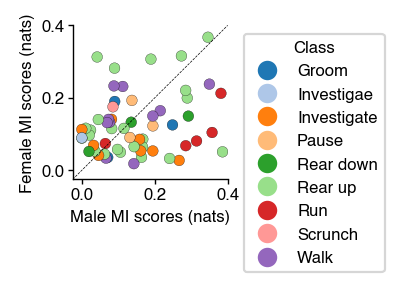

In [15]:
# Label encoding for classes
le = LabelEncoder()
le.fit(np.unique(mi_df['class'].unique()))
mi_df['class_encoded'] = le.transform(mi_df['class'])

# Separate the data into male and female MI scores
m_mi = mi_df[mi_df['exp'] == 'male']
f_mi = mi_df[mi_df['exp'] == 'female']

# Ensure that the syllables are aligned between male and female dataframes
m_mi = m_mi.set_index('syll')
f_mi = f_mi.set_index('syll')

# Merge male and female MI scores based on syllables
merged_mi_df = m_mi[['mi', 'class_encoded']].join(f_mi[['mi']], lsuffix='_male', rsuffix='_female')

# Plot
palette = sns.color_palette("tab20", len(np.unique(mi_df['class'])))
fig, ax = plt.subplots()
fig.set_size_inches(1,1)
sns.scatterplot(data=merged_mi_df, x='mi_male', y='mi_female', hue='class_encoded', palette=palette, s=15,
                edgecolor='black', linewidth=0.1)

# Add labels and title
plt.xlim([-0.025, 0.4])
plt.ylim([-0.025, 0.4])
plt.xlabel('Male MI scores (nats)')
plt.ylabel('Female MI scores (nats)')

# Create legend
legend_labels = le.inverse_transform(range(len(np.unique(mi_df['class']))))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, palette)]
plt.legend(handles=legend_handles, title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add identity line
plt.plot([-0.025, 0.4], [-0.025, 0.4], 'k--', lw=0.25)

sns.despine()
plt.show()

In [16]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ '07_24_fvm_MI_aging_scatter.pdf')